# TD4 - Information Extraction and Knowledge Graph Population


In [22]:
# Imports
from transformers import pipeline
import networkx as nx
import matplotlib.pyplot as plt
import re

In [3]:
triplet_extractor = pipeline('text2text-generation', model='Babelscape/rebel-large', tokenizer='Babelscape/rebel-large')

config.json: 100%|██████████| 1.42k/1.42k [00:00<00:00, 2.10MB/s]
model.safetensors: 100%|██████████| 1.63G/1.63G [00:43<00:00, 37.5MB/s]
All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.
tokenizer_config.json: 100%|██████████| 1.23k/1.23k [00:00<00:00, 4.34MB/s]
vocab.json: 100%|██████████| 798k/798k [00:00<00:00, 1.76MB/s]
merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 1.66MB/s]
tokenizer.json: 100%|██████████| 1.36M/1.36M [00:00<00:00, 11.4MB/s]
special_tokens_map.json: 100%|██████████| 344/344 [00:00<00:00, 1.25MB/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<s><triplet> Punta Cana <subj> La Altagracia Province <obj> located in the administrative territorial entity <subj> Dominican Republic <obj> country <triplet> Higuey <subj> La Altagracia Province <obj> located in the administrative territorial entity <subj> Dominican Republic <obj> country <triplet> La Altagracia Province <subj> Dominican Republic <obj> country <triplet> Dominican Republic <subj> La Altagracia Province <obj> contains administrative territorial entity</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [23]:
with open("./doc.txt") as f:
    text = f.read()

sentences = re.split(r' *[\.\?!][\'"\)\]]* *', text)

print(sentences)

['Geoffrey Everest Hinton (born 6 December 1947) is an English Canadian cognitive\npsychologist and computer scientist, most noted for his work on artificial neural networks', '\nSince 2013 he divides his time working for Google (Google Brain) and the University of\nToronto', 'In 2017, he cofounded and became the Chief Scientific Advisor of the Vector\nInstitute in Toronto', '\nWith David E', 'Rumelhart and Ronald J', 'Williams, Hinton was co-author of a highly cited\npaper published in 1986 that popularized the backpropagation algorithm for training\nmulti-layer neural networks, although they were not the first to propose the approach', '\nHinton is viewed by some as a leading figure in the deep learning community and is\nreferred to by some as the "Godfather of Deep Learning"', 'The dramatic image-recognition\nmilestone of the AlexNet designed by his student Alex Krizhevsky for the ImageNet\nchallenge 2012 helped to revolutionize the field of computer vision', 'Hinton was awarded\nth

In [4]:
extracted_texts = []


# We need to use the tokenizer manually since we need special tokens.
extracted_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor(, return_tensors=True, return_text=False)[0]["generated_token_ids"]])

print(extracted_text[0])

<s><triplet> Punta Cana <subj> La Altagracia Province <obj> located in the administrative territorial entity <subj> Dominican Republic <obj> country <triplet> Higuey <subj> La Altagracia Province <obj> located in the administrative territorial entity <subj> Dominican Republic <obj> country <triplet> La Altagracia Province <subj> Dominican Republic <obj> country <triplet> Dominican Republic <subj> La Altagracia Province <obj> contains administrative territorial entity</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [5]:
# Function to parse the generated text and extract the triplets
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets

In [6]:
extracted_triplets = extract_triplets(extracted_text[0])
print(extracted_triplets)

[{'head': 'Punta Cana', 'type': 'located in the administrative territorial entity', 'tail': 'La Altagracia Province'}, {'head': 'Punta Cana', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'Higuey', 'type': 'located in the administrative territorial entity', 'tail': 'La Altagracia Province'}, {'head': 'Higuey', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'La Altagracia Province', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'Dominican Republic', 'type': 'contains administrative territorial entity', 'tail': 'La Altagracia Province'}]


## NetworkX

Creation of a graph with the triplets extracted from REBEL.

In [19]:
# Creating an empty directed graph
G = nx.DiGraph()

# Creating nodes
for extracted_triplet in extracted_triplets:
    head_node = extracted_triplet["head"]
    type_node = extracted_triplet["type"]
    tail_node = extracted_triplet["tail"]

    # Adding nodes with attributes
    G.add_node(head_node, type=type_node, node_color="lightblue")
    G.add_node(type_node, tail=tail_node, node_color="orange")

    # Adding edges
    G.add_edge(head_node, type_node)
    G.add_edge(type_node, tail_node)

print(G.nodes.data())

[('Punta Cana', {'type': 'country', 'node_color': 'lightblue'}), ('located in the administrative territorial entity', {'tail': 'La Altagracia Province', 'node_color': 'orange'}), ('La Altagracia Province', {'type': 'country', 'node_color': 'lightblue'}), ('country', {'tail': 'Dominican Republic', 'node_color': 'orange'}), ('Dominican Republic', {'type': 'contains administrative territorial entity', 'node_color': 'lightblue'}), ('Higuey', {'type': 'country', 'node_color': 'lightblue'}), ('contains administrative territorial entity', {'tail': 'La Altagracia Province', 'node_color': 'orange'})]


### Visualizing the graph

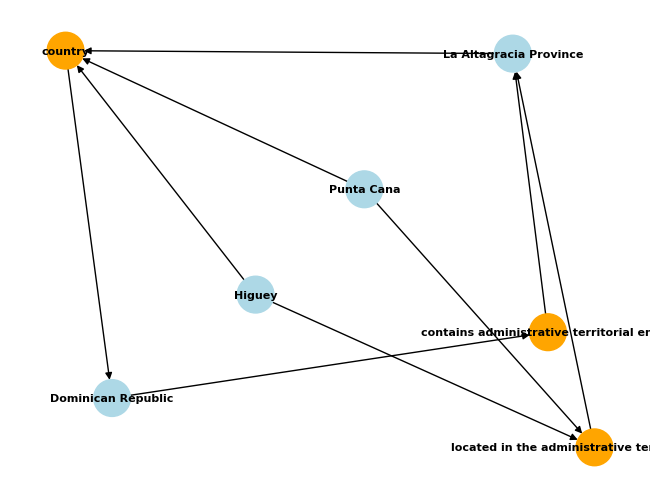

In [21]:
pos = nx.spring_layout(G)

node_colors = [G.nodes[node]["node_color"] for node in G.nodes]

nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color=node_colors, font_size=8)

plt.show()